<a href="https://colab.research.google.com/github/lustea0201/Underdogs/blob/master/Final_project/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the training dataset


In [1]:
!rm -rf data.zip


import zipfile

from google.colab import drive
drive.mount('/content/drive/')

data = zipfile.ZipFile("/content/drive/My Drive/Super Resolution/data.zip", 'r')

data.extractall()
data.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os 
from torchvision.datasets import ImageFolder
from torchvision import transforms





In [3]:
import torch

train = []
test = []

N_train = 70 
N_test = 30 

for s in ["irregular","circle"]:
  for n in ["1","16","32","64"]: 
    X_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/Low", transform = transforms.ToTensor())
    Y_t = ImageFolder(root = "/content/data/" + s + "_" + n + "/High", transform = transforms.ToTensor())
    for i in range(N_test):
      test.append([X_t[i][0], Y_t[i][0]])

    for i in range(N_test, N_train+N_test):
      train.append([X_t[i][0], Y_t[i][0]])

train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=16)
test_loader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=16)
X, Y = next(iter(train_loader))
print(X.shape)


torch.Size([16, 3, 512, 512])


(-0.5, 1023.5, 1023.5, -0.5)

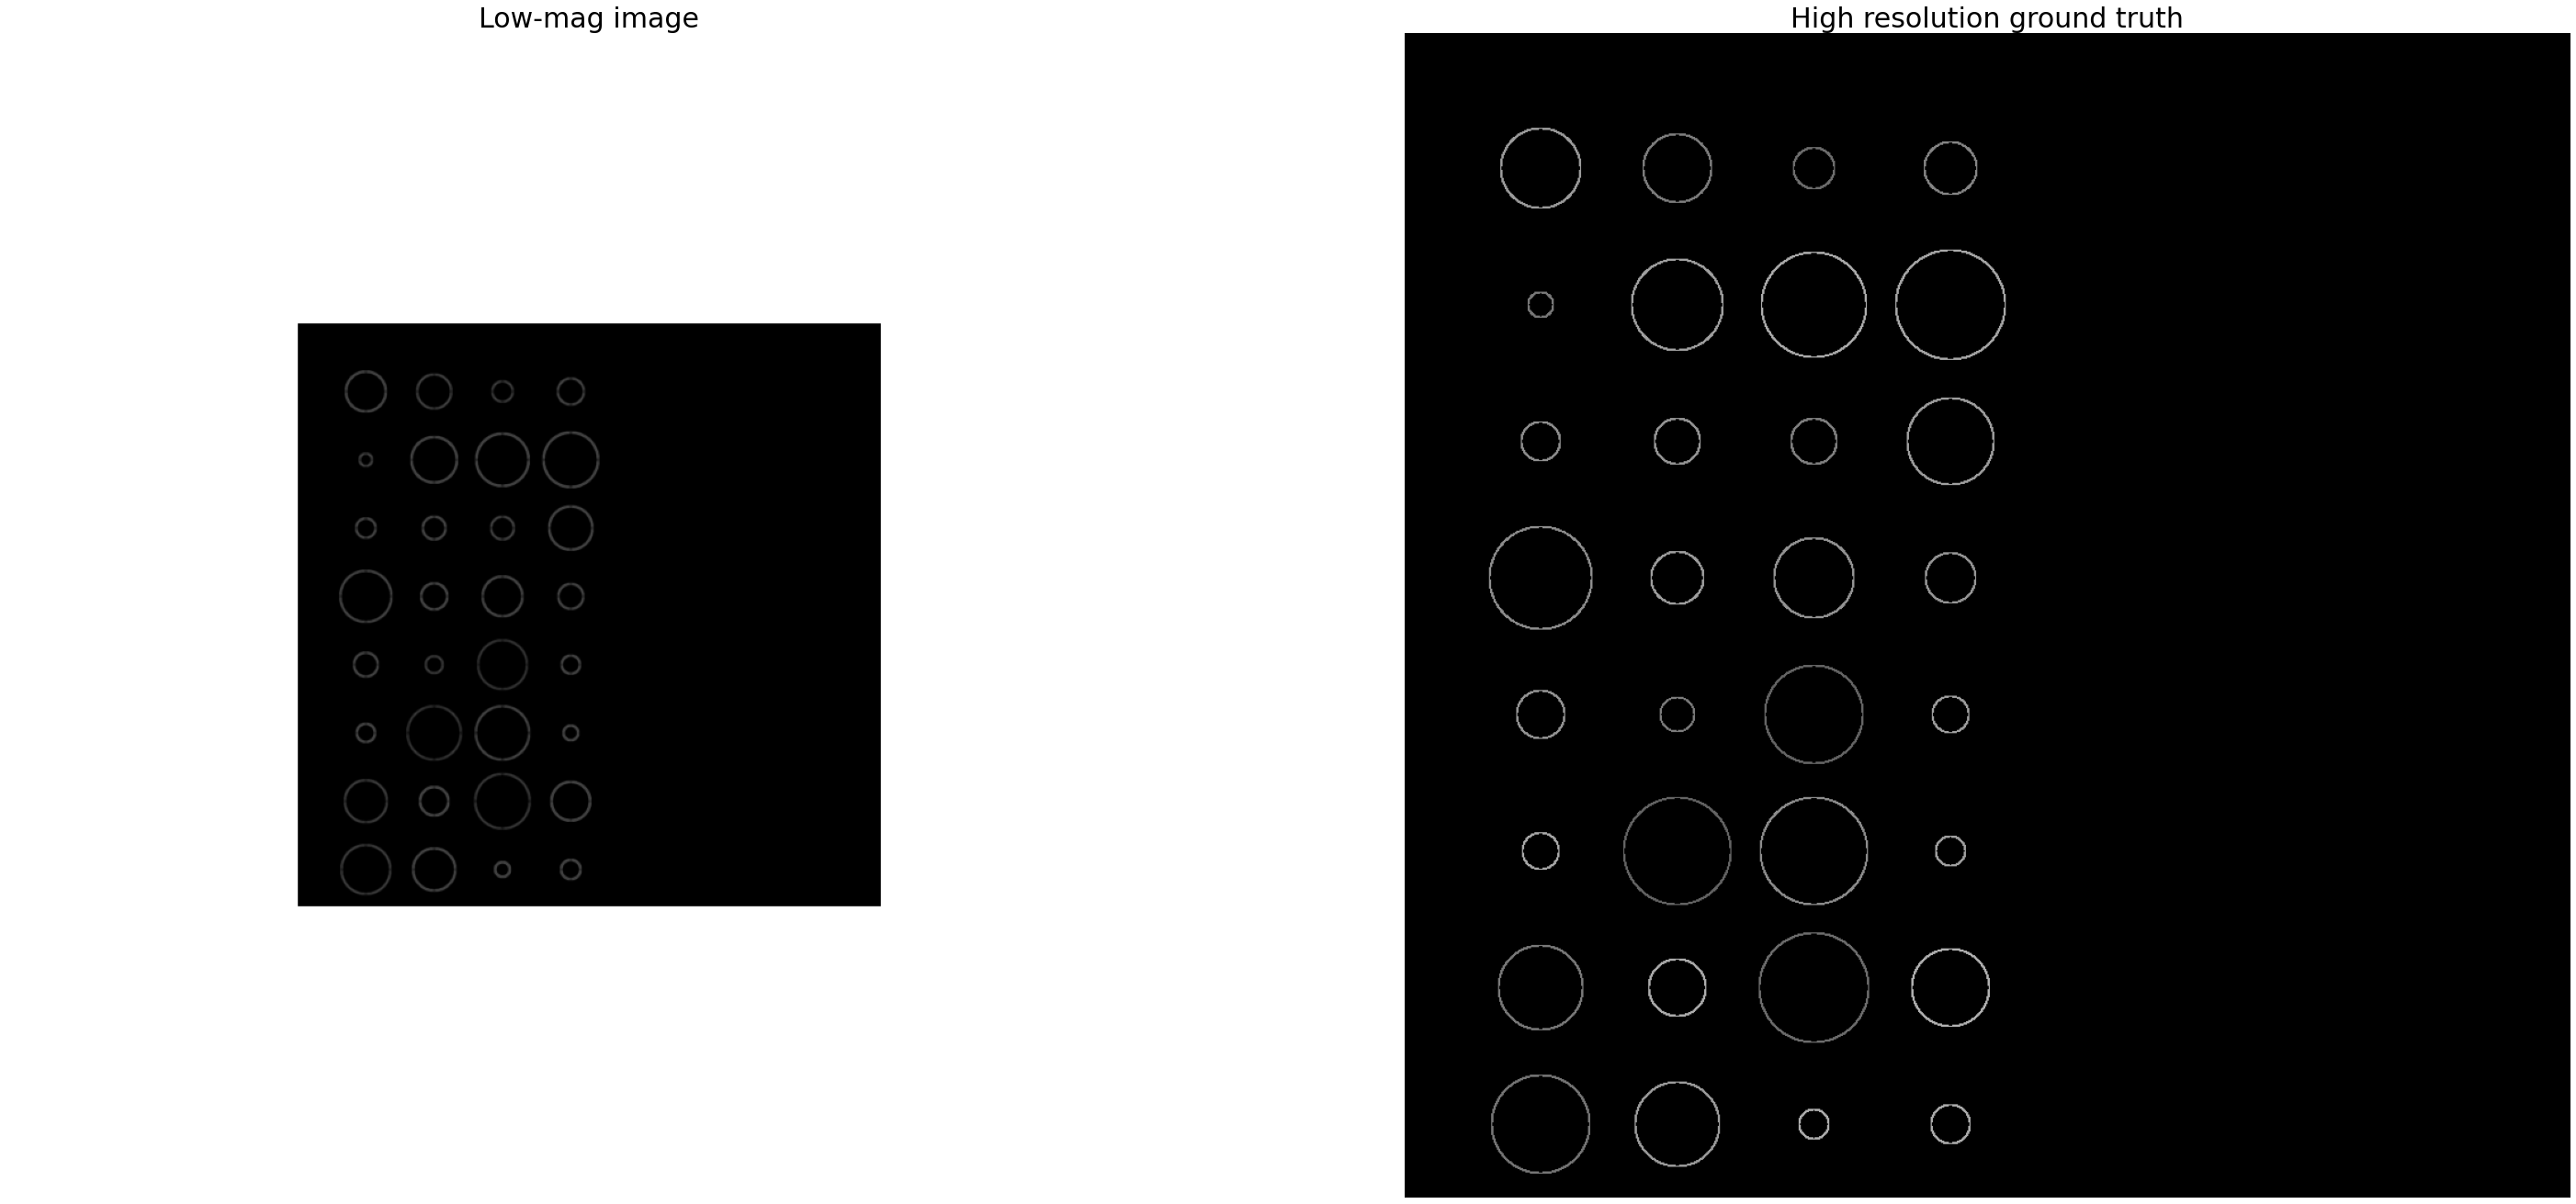

In [4]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize=(50,25))
im_h = Y[0].permute(1, 2, 0)
im_l = torch.ones(im_h.shape) 
height = im_h.shape[0]
width = im_h.shape[1]
im_l[height//4:height-height//4, width//4:width-width//4, :] = X[0].permute(1,2,0)


axes[0].imshow(im_l)
axes[0].set_title("Low-mag image", fontsize=30);
axes[0].axis('off')
axes[1].imshow(im_h)
axes[1].set_title("High resolution ground truth", fontsize=30);
axes[1].axis('off')


In [0]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3*upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)


class Net2(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        return x


In [0]:
import matplotlib.pyplot as plt 
import numpy as np

def compare(p,t, gen): 
  fig, axes = plt.subplots(1,2, figsize=(30,15))

  p = p.cpu().detach()
  t = t.cpu().detach()
  p = (255*p.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[0].imshow(p)
  axes[0].set_title("Prediction (generation %d)" %gen, fontsize=30);
  axes[0].axis('off')

  t = (255*t.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[1].imshow(t)
  axes[1].set_title("High resolution ground truth", fontsize=30);
  axes[1].axis('off')
  plt.show()

In [0]:
import torch.optim as optim
from math import log10



torch.manual_seed(12)

device = torch.device("cuda")

print('===> Building model')
model = Net(upscale_factor=2).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

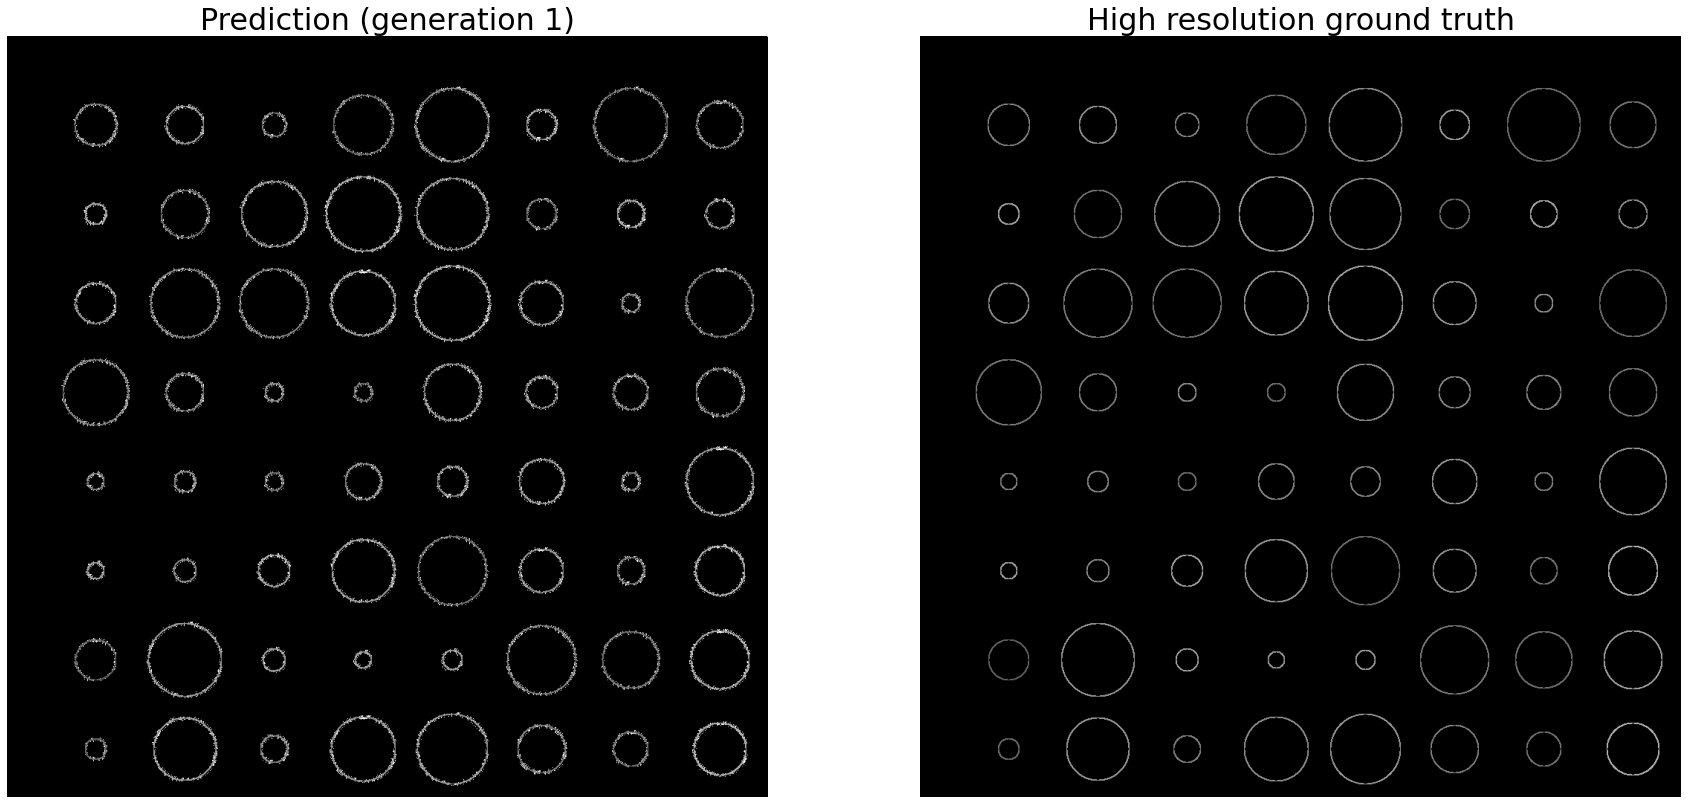

===> Epoch 1 Complete: Avg. Loss: 0.0499
===> Avg. PSNR: 47.1740 dB
===> Epoch 2 Complete: Avg. Loss: 0.0478
===> Avg. PSNR: 47.2029 dB
===> Epoch 3 Complete: Avg. Loss: 0.0477
===> Avg. PSNR: 47.1827 dB
===> Epoch 4 Complete: Avg. Loss: 0.0476
===> Avg. PSNR: 47.1393 dB
===> Epoch 5 Complete: Avg. Loss: 0.0476
===> Avg. PSNR: 47.1840 dB
===> Epoch 6 Complete: Avg. Loss: 0.0476
===> Avg. PSNR: 47.1543 dB
===> Epoch 7 Complete: Avg. Loss: 0.0477
===> Avg. PSNR: 47.0849 dB
===> Epoch 8 Complete: Avg. Loss: 0.0475
===> Avg. PSNR: 47.2290 dB
===> Epoch 9 Complete: Avg. Loss: 0.0475
===> Avg. PSNR: 47.2073 dB
===> Epoch 10 Complete: Avg. Loss: 0.0475
===> Avg. PSNR: 47.1851 dB


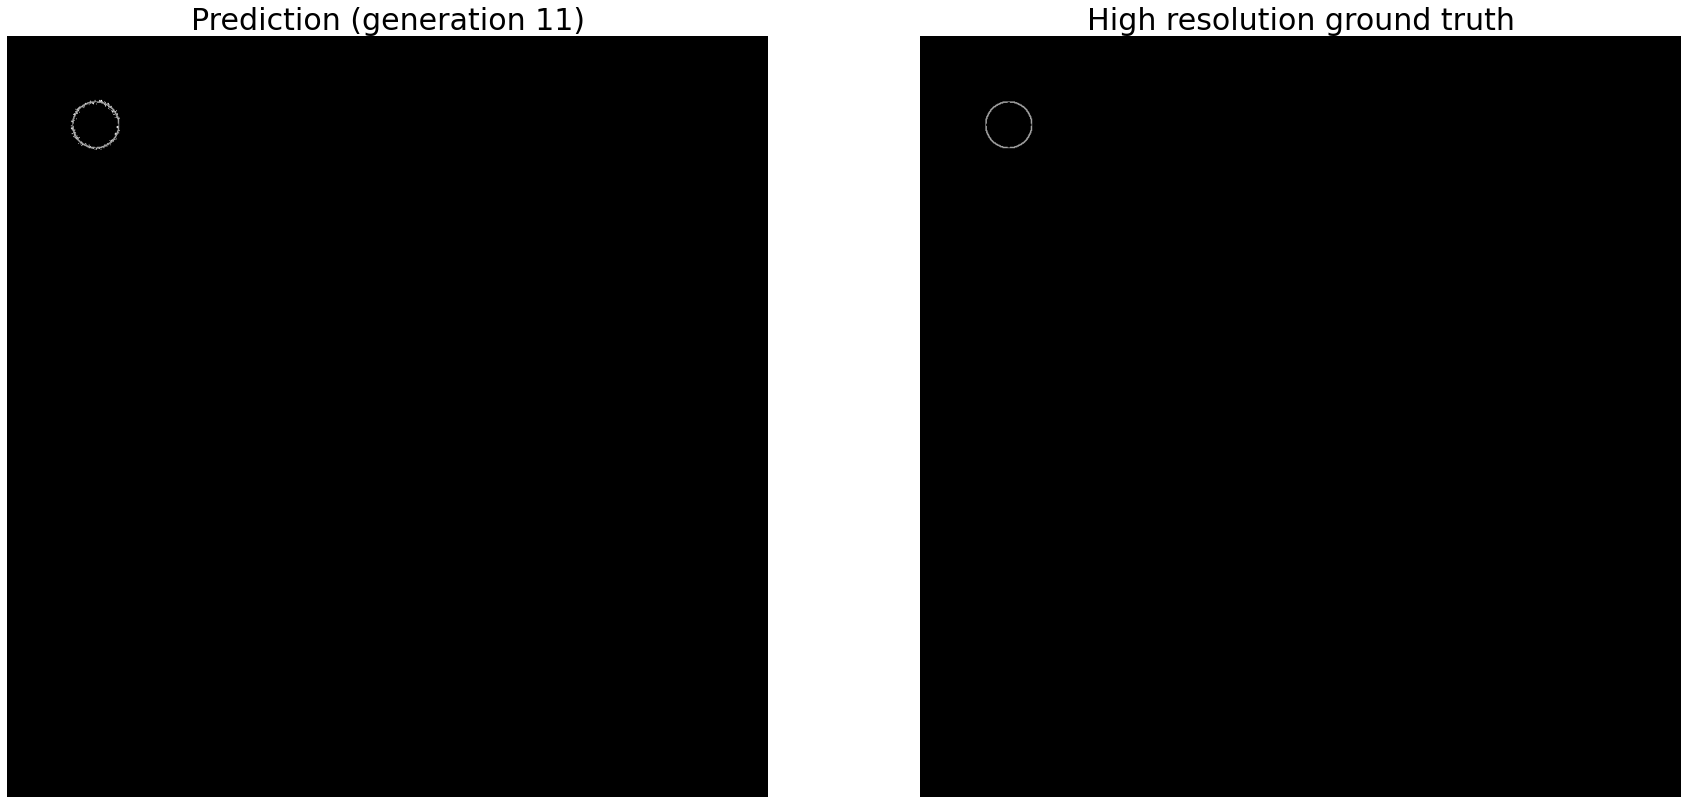

===> Epoch 11 Complete: Avg. Loss: 0.0476
===> Avg. PSNR: 47.2013 dB
===> Epoch 12 Complete: Avg. Loss: 0.0473
===> Avg. PSNR: 47.2594 dB
===> Epoch 13 Complete: Avg. Loss: 0.0473
===> Avg. PSNR: 47.2362 dB
===> Epoch 14 Complete: Avg. Loss: 0.0474
===> Avg. PSNR: 47.2375 dB
===> Epoch 15 Complete: Avg. Loss: 0.0473
===> Avg. PSNR: 47.2463 dB
===> Epoch 16 Complete: Avg. Loss: 0.0472
===> Avg. PSNR: 47.2463 dB
===> Epoch 17 Complete: Avg. Loss: 0.0472
===> Avg. PSNR: 47.2111 dB
===> Epoch 18 Complete: Avg. Loss: 0.0472
===> Avg. PSNR: 47.2514 dB
===> Epoch 19 Complete: Avg. Loss: 0.0473
===> Avg. PSNR: 47.2599 dB


In [31]:

l = []

def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(train_loader, 1):
        input_, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        pred = model(input_)
        loss = criterion(pred, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{})".format(epoch, iteration, len(train_loader)), end="\r")

    if epoch % 10 == 1:
      compare(pred[0], target[0], epoch)
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, 1000*epoch_loss / len(train_loader)))
    l.append(1000*epoch_loss / len(train_loader))


def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in test_loader:
            input_, target = batch[0].to(device), batch[1].to(device)
            prediction = model(input_)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr

    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test_loader)))



for epoch in range(1, 20):
    train(epoch)
    test()


In [32]:
#save = input("Overwrite current state dictionnary ? [y/n]")
save = 'y'
if (save == 'y'): 
  torch.save(model.state_dict(), 'drive/My Drive/Super Resolution/model.pth')
  print("State dictionnary saved.")
else: 
  print("State dictionnary has not been saved.")

State dictionnary saved.
